In [1]:
from os import chdir
chdir('..')

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import math
import seaborn as sns
import pandas as pd
import numpy as np
from polylidar import extractPlanesAndPolygons, extractPolygons
from shapely.geometry import LineString, Polygon, box
from matplotlib.patches import PathPatch, Path
from shapely.affinity import scale
from matplotlib.transforms import Bbox
import base64


from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes, plot_poly
from concave_evaluation.test_generation import random_points_within
from concave_evaluation.polylidar_evaluation import convert_to_shapely_polygons
%matplotlib inline
sns.set()
sns.set_style("white")

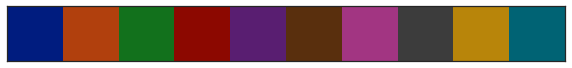

In [3]:
colors_rgb = np.array([[1,1,1], *plt.cm.tab20.colors])
colors_rgba = np.ones((colors_rgb.shape[0], 4))
colors_rgba[:,:3] = colors_rgb
custom_cmap = ListedColormap(colors_rgba.tolist())


current_palette = sns.color_palette('dark')
sns.palplot(current_palette)

PURPLE = current_palette[4]
PURPLE_LIGHT = current_palette[4] + (0.1, )
GREEN = current_palette[2]
GREEN_LIGHT = current_palette[2] + (0.1, )
RED = current_palette[3]
BLUE = current_palette[0]
BLUE_LIGHT = current_palette[0] + (0.1, )
ORANGE = current_palette[1]
ORANGE_LIGHT = current_palette[1] + (0.1, )
GRAY = current_palette[7] + (0.7, )
GRAY_LIGHT = current_palette[7] + (0.3, )

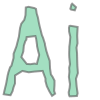

In [4]:
points = np.load("assets/pics/lettera.npy")
# Extract Polylidar polgyons
mesh, planes, polygons = extractPlanesAndPolygons(points, alpha=0.0, lmax=2.0, minTriangles=10)
concave_polygons = convert_to_shapely_polygons(
    polygons, points, return_first=False)

triangles = np.array(mesh.triangles)
tri_shape = (int(triangles.shape[0] / 3), 3)
triangles = np.reshape(triangles, tri_shape)

concave_polygons

In [5]:
def write_video(video, fname):
    start = video.find("base64,") + 7
    end = video.find("\">") - 1
    print(start, end)
    video_data = base64.b64decode(video[start:end])
    with open('assets/pics/'+fname, 'wb') as fp:
        fp.write(video_data)

In [6]:
def valid_triangles_mask(planes, tri_shape):
    all_tris_valid = np.concatenate(planes, axis=0)
    plane_tri_counts = [len(plane) for plane in planes]
    for i in range(len(plane_tri_counts)):
        if i == 0:
            continue
        plane_tri_counts[i] = plane_tri_counts[i-1] + plane_tri_counts[i] 
    mask_array = np.zeros(tri_shape[0], dtype=bool)
    mask_array[all_tris_valid]= True
    return mask_array, all_tris_valid, plane_tri_counts

def plot_base(points, triangles, initial_colors, valid_tri_mask=None, plot_points=True, plot_filtered_tris=True):
    fig, ax = plt.subplots(figsize=(6,8))
    artist_scatter = None
    tri_artist = []
    if plot_points:
        artist_scatter = ax.scatter(points[:, 0], points[:,1], c='k')

    if valid_tri_mask is None and triangles is not None:
        artist_tri_1 = plt.triplot(points[:, 0], points[:,1], triangles=triangles, c='k', alpha=1.0)
        tri_artist = [artist_tri_1]
    elif triangles is not None:
        artist_tri_1 = plt.triplot(points[:, 0], points[:,1], triangles=triangles, c='k', alpha=1.0, mask=~valid_tri_mask)
        if plot_filtered_tris:
            artist_tri_2 = plt.triplot(points[:, 0], points[:,1], triangles=triangles, c='k', alpha=0.30, mask=valid_tri_mask)
            artist_tri_3 = plt.tripcolor(points[:, 0], points[:,1], triangles=triangles, facecolors=initial_colors, mask=~valid_tri_mask, cmap=custom_cmap, alpha=0.0)
            tri_artist = [artist_tri_3, *artist_tri_1, *artist_tri_2]
        else:
            tri_artist = [*artist_tri_1]
#         print(dir(artist_tri_3))
#         print(artist_tri_3)
#         print(artist_tri_3.get_children())
#         print(artist_tri_3.get_())
#         print(artist_tri_3.get_cmap()(1))
#         initial_colors[:100] = 4
#         print(artist_tri_3.get_cmap()(initial_colors[~valid_tri_mask]))
#         artist_tri_3.set_facecolor(artist_tri_3.get_cmap()(initial_colors[~valid_tri_mask]))
#         print(artist_tri_3.get_array())
#         print(artist_tri_3.set_array(initial_colors[valid_tri_mask]))
#         print(artist_tri_3.get_array())
#         artist_tri_3.draw()
#         fig.canvas.draw_idle()
    ax.axis("equal")
    if plot_points:
        tri_artist.append(artist_scatter)
    return fig, ax, tri_artist


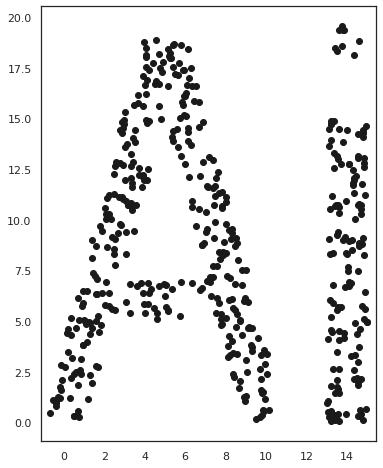

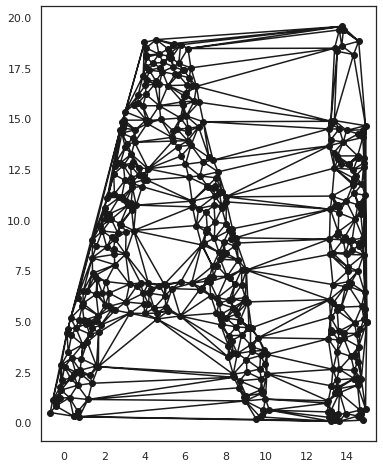

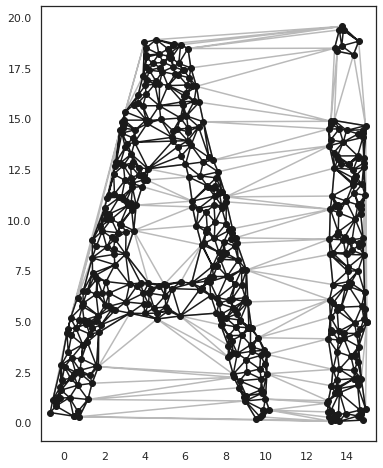

In [7]:
valid_tri_mask, all_valid_tris, plane_tri_counts = valid_triangles_mask(planes, triangles.shape)
initial_colors = np.zeros((triangles.shape[0], ), dtype=int)
fig, ax, tri_arist = plot_base(points, None, initial_colors, valid_tri_mask=None )
fig.savefig('assets/pics/algorithm_explained_points.pdf', bbox_inches='tight')

fig, ax, tri_arist = plot_base(points, triangles, initial_colors, valid_tri_mask=None )
fig.savefig('assets/pics/algorithm_explained_delaunay.pdf', bbox_inches='tight')

fig, ax, tri_arist = plot_base(points, triangles, initial_colors, valid_tri_mask=valid_tri_mask )
fig.savefig('assets/pics/algorithm_explained_delaunay_filtered.pdf', bbox_inches='tight')

110 266416


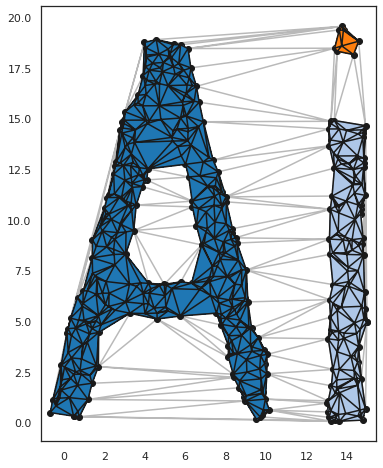

In [8]:
def create_region_growing_animation(points, planes, triangles, interval=5):

    valid_tri_mask, all_valid_tris, plane_tri_counts = valid_triangles_mask(planes, tri_shape)
    initial_colors = np.zeros((triangles.shape[0], ), dtype=int)
    fig, ax, tri_artists = plot_base(points, triangles, initial_colors, valid_tri_mask=valid_tri_mask)

    total_frames = np.count_nonzero(valid_tri_mask)

    def init():
        return tri_artists

    def update_color_array(initial_colors, tri_idx, group_num=1):
        pass
        initial_colors[tri_idx] = group_num

    def update(frame):
        tri_idx = all_valid_tris[frame]
        artist_tri_3 = tri_artists[0]
        group_num = 0
        for plane_num, count in enumerate(plane_tri_counts):
            if frame < count:
                group_num = plane_num + 1
                break
            else:
                group_num = len(plane_tri_counts) + 1

        update_color_array(initial_colors, tri_idx, group_num=group_num)
        artist_tri_3._facecolors = custom_cmap(initial_colors[valid_tri_mask])

        return tri_artists

    ani = FuncAnimation(fig, update, frames=total_frames,
                        init_func=init, blit=True, interval=interval)
    return ani

ani = create_region_growing_animation(points, planes, triangles)

video = ani.to_html5_video()

write_video(video, "algorithm_explained_region_growing.mp4")

HTML(video)


In [9]:
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch

def get_point(pi, points):
    """Get a point from a numpy array.
    If the numpy array has 3 dimensions, will return all three (x,y,z)
    Arguments:
        pi {int} -- Point index in numpy array
        points {ndarray} -- Numpy array of points
    
    Returns:
        [list] -- List of poins [x,y,(z)]
    """
    if points.shape[1] > 2:
        return [points[pi, 0], points[pi, 1], points[pi, 2]]
    else:
        return [points[pi, 0], points[pi, 1]]

def plot_polygons(polygons, points, ax, linewidth=2, shell_color='green', hole_color='orange'):
    for poly in polygons:
        shell_coords = [get_point(pi, points) for pi in poly.shell]
        outline = Polygon(shell=shell_coords)
        outlinePatch = PolygonPatch(outline, ec=shell_color, fill=False, linewidth=linewidth, zorder=4)
        ax.add_patch(outlinePatch)

        for hole_poly in poly.holes:
            shell_coords = [get_point(pi, points) for pi in hole_poly]
            outline = Polygon(shell=shell_coords)
            outlinePatch = PolygonPatch(outline, ec=hole_color, fill=False, linewidth=linewidth,zorder=4)
            ax.add_patch(outlinePatch)

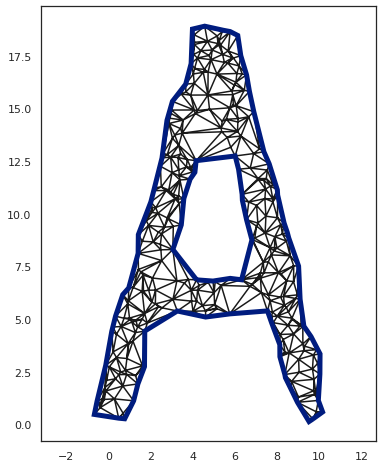

In [10]:
valid_tri_mask, all_valid_tris, plane_tri_counts = valid_triangles_mask(planes[:1], triangles.shape)
initial_colors = np.zeros((triangles.shape[0], ), dtype=int)
fig, ax, tri_arist = plot_base(points, triangles, initial_colors, valid_tri_mask=valid_tri_mask, plot_points=False, plot_filtered_tris=False)
polygon = concave_polygons.geoms[0]
plot_polygons([polygons[0]], points, ax, linewidth=5, shell_color=BLUE, hole_color=BLUE)
plt.show()
fig.savefig('assets/pics/algorithm_explained_boundary.pdf', bbox_inches='tight')

[<matplotlib.lines.Line2D object at 0x7fd80bbdca10>, <matplotlib.lines.Line2D object at 0x7fd80bbdcb50>]
110 50131


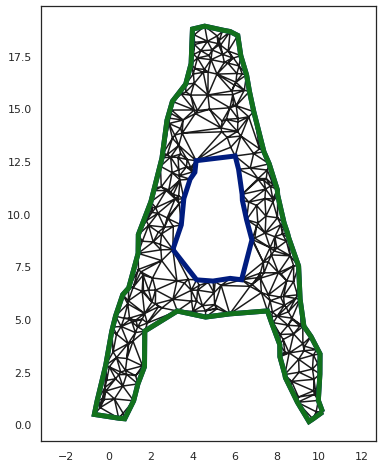

In [11]:
def create_linear_ring_growing_animation(points, planes, polygons, triangles, shell=True, interval=60):

    valid_tri_mask, all_valid_tris, plane_tri_counts = valid_triangles_mask(planes[:1], triangles.shape)
    initial_colors = np.zeros((triangles.shape[0], ), dtype=int)
    fig, ax, tri_artists = plot_base(points, triangles, initial_colors, valid_tri_mask=valid_tri_mask, plot_points=False, plot_filtered_tris=False)

    print(tri_artists)
    polygon =  polygons[0]
    lr_shell = np.roll(list(polygon.shell), 1)
    lr_holes = np.roll(list(polygon.holes[0]), 1)
    
    lr_shell = np.append(lr_shell, lr_shell[0])
    lr_holes = np.append(lr_holes, lr_holes[0])
    
    ec = GREEN if shell else ORANGE
    
    
    coords_shell = np.array([get_point(pi, points) for pi in lr_shell])
    coords_holes = np.array([get_point(pi, points) for pi in lr_holes])
    
    
    if shell:
        border_patch_1 = PathPatch(Path(coords_shell), fill=False, ec=BLUE, linewidth=5, zorder=3)
        border_patch_2 = PathPatch(Path(coords_holes), fill=False, ec=BLUE, linewidth=5, zorder=3)
        path_patch = PathPatch(Path(coords_shell), fill=False, ec=GREEN, linewidth=5, zorder=4)
        
        ax.add_patch(border_patch_1)
        ax.add_patch(border_patch_2)
        coords = coords_shell
    else:
        border_patch_1 = PathPatch(Path(coords_shell), fill=False, ec=GREEN, linewidth=5, zorder=3)
        border_patch_2 = PathPatch(Path(coords_holes), fill=False, ec=BLUE, linewidth=5, zorder=3)
        path_patch = PathPatch(Path(coords_holes), fill=False, ec=ORANGE, linewidth=5, zorder=4)
        
        ax.add_patch(border_patch_1)
        ax.add_patch(border_patch_2)
        coords = coords_holes
    
    
#     if shell is False:
        
    
    tri_artists.insert(0, path_patch)
    ax.add_patch(path_patch)

    total_frames = coords.shape[0] +20

    def init():
        return tri_artists


    def update(frame):

        new_coords = coords[:frame+1, :]
        path_patch._path = Path(new_coords)
        
        return tri_artists

    ani = FuncAnimation(fig, update, frames=total_frames,
                        init_func=init, blit=True, interval=interval)
    return ani, fig

ani, fig = create_linear_ring_growing_animation(points, planes, polygons, triangles)
video = ani.to_html5_video()
# print(video[110:47909])
# print(video)
write_video(video, "algorithm_explained_shell_extraction.mp4")
HTML(video)


[<matplotlib.lines.Line2D object at 0x7fd80cd8add0>, <matplotlib.lines.Line2D object at 0x7fd80cd8aad0>]
110 40474


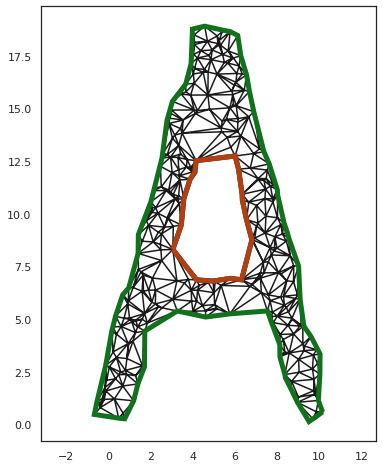

In [12]:
ani, fig = create_linear_ring_growing_animation(points, planes, polygons, triangles, shell=False)
video = ani.to_html5_video()
write_video(video, "algorithm_explained_hole_extraction.mp4")
HTML(video)